In [1]:
import pandas as pd

ames_housing = pd.read_csv("../datasets/ames_housing_no_missing.csv")
target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

In [2]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

for mod in [LinearRegression, DecisionTreeRegressor]:
    if mod == LinearRegression:
        model = make_pipeline(StandardScaler(), SimpleImputer(), mod())
    else:
        model = make_pipeline(SimpleImputer(), mod(random_state=42))
        
    cv_results = cross_validate(model,data_numerical, target, cv=10, n_jobs=2, return_estimator=True)
    s = cv_results["test_score"]
    
    print(f"{mod.__name__:22}: mean: "
          f"{s.mean():.3f} STD: {s.std():.2f}"
         )

LinearRegression      : mean: 0.719 STD: 0.14
DecisionTreeRegressor : mean: 0.619 STD: 0.09


In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV

tree = make_pipeline(SimpleImputer(), DecisionTreeRegressor(random_state=42))
params = {"decisiontreeregressor__max_depth": np.arange(1, 15)}
search = GridSearchCV(tree, params, cv=10)
cv_results_tree_optimal_depth = cross_validate(
    search, data_numerical, target, cv=10, return_estimator=True, n_jobs=2,
)
cv_results_tree_optimal_depth["test_score"].mean()

0.6616558623470568

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='max depth'>

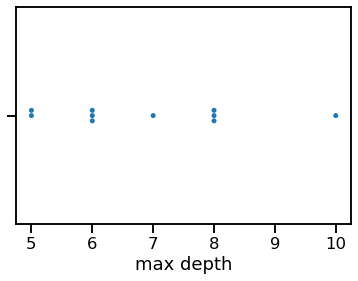

In [8]:
import seaborn as sns
sns.set_context("talk")

max_depth = [
    estimator.best_params_["decisiontreeregressor__max_depth"]
    for estimator in cv_results_tree_optimal_depth["estimator"]
]
max_depth = pd.Series(max_depth, name="max depth")
sns.swarmplot(max_depth)

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder

categorical_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)
numerical_processor = SimpleImputer()


preprocessor = make_column_transformer(
    (categorical_processor, selector(dtype_include=object)),
    (numerical_processor, selector(dtype_exclude=object))
)
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=0))

In [11]:
cv_results = cross_validate(
    tree, data, target, cv=10, return_estimator=True, n_jobs=2
)
cv_results["test_score"].mean()

0.730196606256636